In [1]:
import findspark
findspark.init()
from pyspark import SparkConf
from pyspark.sql import SparkSession, SQLContext, functions as F

In [2]:
# Configuración local
configuraDierickBrochero = (
    SparkConf()
        .set("spark.scheduler.mode", "FAIR")
        .set("spark.executor.memory", "10G")
        .set("spark.executor.cores", "1")
        .set("spark.cores.max", "9")
        .set("spark.ui.port", "4040")
        .setMaster("local[*]")  # <---- Spark local usando todos los cores
        .setAppName("hpcsparkDierickBrochero")
)

# Crear sesión Spark local
sparkDierickBrochero = (
    SparkSession
        .builder
        .config(conf=configuraDierickBrochero)
        .getOrCreate()
)

sqlContext = SQLContext(sparkDierickBrochero.sparkContext)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/25 19:07:26 WARN Utils: Your hostname, MacBook-Pro-de-Dierick.local, resolves to a loopback address: 127.0.0.1; using 10.211.55.2 instead (on interface bridge100)
25/11/25 19:07:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/25 19:07:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/homebrew/opt/apache-spark/libexec/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
df = sparkDierickBrochero.read.csv("predictive_maintenance.csv", header=True, inferSchema=True)

In [4]:
df = (
    df
    .withColumnRenamed("Product ID", "product_id")
    .withColumnRenamed("Air temperature [K]", "air_temp")
    .withColumnRenamed("Process temperature [K]", "process_temp")
    .withColumnRenamed("Rotational speed [rpm]", "rotational_speed")
    .withColumnRenamed("Torque [Nm]", "torque")
    .withColumnRenamed("Tool wear [min]", "tool_wear")
    .withColumnRenamed("Failure Type", "failure_Type")
)

In [5]:
minority = df.filter(df["Target"] == 1)
majority = df.filter(df["Target"] == 0)

# Muestreo aleatorio de la clase mayoritaria
majority_downsampled = majority.sample(
    withReplacement=False, 
    fraction=minority.count()/majority.count(), 
    seed=42
)

balancedDF = majority_downsampled.union(minority)
balancedDF.groupBy("Target").count().show()

+------+-----+
|Target|count|
+------+-----+
|     0|  366|
|     1|  339|
+------+-----+



# Pipelines

In [6]:
train_pip, test_pip = balancedDF.randomSplit([0.7, 0.3])

In [7]:
# Verificar el esquema y datos del DataFrame
print("Esquema de train_pip:")
train_pip.printSchema()

print("\nConteo de clases:")
train_pip.groupBy("Target").count().show()

print("\nValores nulos por columna:")
from pyspark.sql.functions import col, sum as spark_sum
null_counts = train_pip.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in train_pip.columns])
null_counts.show()

print("\nMuestra de datos:")
train_pip.show(5)

Esquema de train_pip:
root
 |-- UDI: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- process_temp: double (nullable = true)
 |-- rotational_speed: integer (nullable = true)
 |-- torque: double (nullable = true)
 |-- tool_wear: integer (nullable = true)
 |-- Target: integer (nullable = true)
 |-- failure_Type: string (nullable = true)


Conteo de clases:
+------+-----+
|Target|count|
+------+-----+
|     0|  246|
|     1|  237|
+------+-----+


Valores nulos por columna:
+---+----------+----+--------+------------+----------------+------+---------+------+------------+
|UDI|product_id|Type|air_temp|process_temp|rotational_speed|torque|tool_wear|Target|failure_Type|
+---+----------+----+--------+------------+----------------+------+---------+------+------------+
|  0|         0|   0|       0|           0|               0|     0|        0|     0|           0|
+---+----------+----+--------+--

In [8]:
# Eliminar columnas problemáticas y asegurar tipos de datos correctos
from pyspark.sql.types import DoubleType, StringType
from pyspark.sql.functions import col

# Seleccionar y convertir columnas relevantes
cleaned_train = train_pip.select(
    col("UDI").cast("int"),
    col("product_id").cast("string"),
    col("Type").cast("string"),
    col("air_temp").cast("double"),
    col("process_temp").cast("double"),
    col("rotational_speed").cast("double"),
    col("torque").cast("double"),
    col("tool_wear").cast("int"),
    col("Target").cast("int"),
    col("failure_Type").cast("string")
).filter(
    col("air_temp").isNotNull() &
    col("process_temp").isNotNull() &
    col("rotational_speed").isNotNull() &
    col("torque").isNotNull() &
    col("tool_wear").isNotNull() &
    col("Target").isNotNull()
)

cleaned_test = test_pip.select(
    col("UDI").cast("int"),
    col("product_id").cast("string"),
    col("Type").cast("string"),
    col("air_temp").cast("double"),
    col("process_temp").cast("double"),
    col("rotational_speed").cast("double"),
    col("torque").cast("double"),
    col("tool_wear").cast("int"),
    col("Target").cast("int"),
    col("failure_Type").cast("string")
).filter(
    col("air_temp").isNotNull() &
    col("process_temp").isNotNull() &
    col("rotational_speed").isNotNull() &
    col("torque").isNotNull() &
    col("tool_wear").isNotNull() &
    col("Target").isNotNull()
)

print(f"Train count after cleaning: {cleaned_train.count()}")
print(f"Test count after cleaning: {cleaned_test.count()}")

Train count after cleaning: 483
Test count after cleaning: 222


In [9]:
from pyspark.ml.feature import RFormula, VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

rForm = RFormula(
    formula="Target ~ air_temp + process_temp + rotational_speed + torque + tool_wear + Type"
).setFeaturesCol("features").setLabelCol("label")

assembler = VectorAssembler(
    inputCols=["air_temp", "process_temp", "rotational_speed", "torque", "tool_wear", "Type_indexed"],
    outputCol="features"
)

type_indexer = StringIndexer(inputCol="Type", outputCol="Type_indexed")

lr = LogisticRegression(
    labelCol="label",
    featuresCol="features",
    maxIter=50,  # Reducir iteraciones para debugging
    regParam=0.01
)

In [10]:
# Crear pipeline
stages = [type_indexer, assembler, lr]
pipeline = Pipeline(stages=stages)

In [11]:
# Configurar parámetros más simples para debugging
from pyspark.ml.tuning import ParamGridBuilder

params = ParamGridBuilder()\
    .addGrid(rForm.formula, [
        "Target ~ . + Type:air_temp",
        "Target ~ . + Type:air_temp + Type:process_temp",
        "Target ~ . + Type:air_temp + Type:process_temp + Type:rotational_speed",
        "Target ~ . + Type:air_temp + Type:process_temp + Type:rotational_speed + Type:torque",
    ])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.regParam, [0.01, 0.1])\
    .build()

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Configurar evaluador
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)


In [13]:
from pyspark.ml.tuning import TrainValidationSplit

# Configurar TrainValidationSplit
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=params,
    evaluator=evaluator,
    trainRatio=0.8,  # Mayor proporción para entrenamiento
    seed=42
)

In [14]:
# Asegurar que tenemos la columna 'label' requerida
prepared_train = cleaned_train.withColumn("label", col("Target"))
prepared_test = cleaned_test.withColumn("label", col("Target"))

print("Esquema final:")
prepared_train.printSchema()

Esquema final:
root
 |-- UDI: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- air_temp: double (nullable = true)
 |-- process_temp: double (nullable = true)
 |-- rotational_speed: double (nullable = true)
 |-- torque: double (nullable = true)
 |-- tool_wear: integer (nullable = true)
 |-- Target: integer (nullable = true)
 |-- failure_Type: string (nullable = true)
 |-- label: integer (nullable = true)



In [15]:
try:
    # Entrenar con un subconjunto más pequeño primero para debugging
    sample_train = prepared_train.sample(0.5, seed=42)
    print(f"Training on sample: {sample_train.count()} rows")
    
    # Entrenar el modelo
    tvsFitted = tvs.fit(sample_train)
    
    print("✅ Model training completed successfully!")
    
    # Evaluar en test
    test_predictions = tvsFitted.transform(prepared_test)
    auc = evaluator.evaluate(test_predictions)
    print(f"🎯 Area under ROC on test set: {auc:.4f}")
    
except Exception as e:
    print(f"❌ Error during training: {e}")
    print("Trying alternative approach...")
    
    # Approach alternativo: entrenar modelo simple sin tuning
    simple_lr = LogisticRegression(
        labelCol="label",
        featuresCol="features",
        maxIter=10
    )
    
    simple_pipeline = Pipeline(stages=[type_indexer, assembler, simple_lr])
    simple_model = simple_pipeline.fit(prepared_train)
    test_simple = simple_model.transform(prepared_test)
    simple_auc = evaluator.evaluate(test_simple)
    print(f"🔧 Simple model AUC: {simple_auc:.4f}")

Training on sample: 230 rows


25/11/25 19:07:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/25 19:07:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


✅ Model training completed successfully!
🎯 Area under ROC on test set: 0.8810


# Entrenar Con Todos los Datos

In [16]:
print(f"Entrenando con todos los datos: {prepared_train.count()} filas")
tvsFitted_full = tvs.fit(prepared_train)

# Evaluar en el conjunto de prueba completo
test_predictions_full = tvsFitted_full.transform(prepared_test)
auc_full = evaluator.evaluate(test_predictions_full)
print(f"🎯 Area under ROC (modelo completo): {auc_full:.4f}")

Entrenando con todos los datos: 483 filas
🎯 Area under ROC (modelo completo): 0.8888


In [17]:
# Obtener el mejor modelo de la validación
best_model = tvsFitted_full.bestModel

# Extraer las etapas de la pipeline
stages = best_model.stages
print("Etapas de la pipeline:")
for i, stage in enumerate(stages):
    print(f"{i}: {type(stage).__name__}")

# Obtener el modelo de Logistic Regression
lr_model = stages[-1]  # Última etapa es el modelo LR

print(f"\n📊 Parámetros del mejor modelo:")
print(f"Coeficientes: {len(lr_model.coefficients)}")
print(f"Intercepto: {lr_model.intercept:.4f}")
print(f"RegParam: {lr_model.getRegParam()}")
print(f"ElasticNetParam: {lr_model.getElasticNetParam()}")

Etapas de la pipeline:
0: StringIndexerModel
1: VectorAssembler
2: LogisticRegressionModel

📊 Parámetros del mejor modelo:
Coeficientes: 6
Intercepto: -28.0807
RegParam: 0.01
ElasticNetParam: 1.0


In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when

# Calcular varias métricas
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)
auc = binary_evaluator.evaluate(test_predictions_full)

binary_evaluator_pr = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)
aupr = binary_evaluator_pr.evaluate(test_predictions_full)

# Métricas de clasificación multiclase
multi_evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = multi_evaluator_accuracy.evaluate(test_predictions_full)

multi_evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)
f1 = multi_evaluator_f1.evaluate(test_predictions_full)

print("\n📈 MÉTRICAS DEL MODELO:")
print(f"Área bajo la curva ROC (AUC): {auc:.4f}")
print(f"Área bajo la curva Precision-Recall: {aupr:.4f}")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Puntuación F1: {f1:.4f}")


📈 MÉTRICAS DEL MODELO:
Área bajo la curva ROC (AUC): 0.8888
Área bajo la curva Precision-Recall: 0.8797
Exactitud (Accuracy): 0.8108
Puntuación F1: 0.8100


In [19]:
# Crear matriz de confusión
confusion_matrix = test_predictions_full\
    .groupBy("label", "prediction")\
    .count()\
    .orderBy("label", "prediction")

print("\n🎯 MATRIZ DE CONFUSIÓN:")
print("(label vs prediction)")
confusion_matrix.show()

# Calcular métricas específicas
confusion_pd = confusion_matrix.toPandas()
confusion_dict = {(row['label'], row['prediction']): row['count'] for row in confusion_pd.to_dict('records')}

tp = confusion_dict.get((1.0, 1.0), 0)
fp = confusion_dict.get((0.0, 1.0), 0)
tn = confusion_dict.get((0.0, 0.0), 0)
fn = confusion_dict.get((1.0, 0.0), 0)

print(f"\n📊 ESTADÍSTICAS DETALLADAS:")
print(f"Verdaderos Positivos (TP): {tp}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Negativos (FN): {fn}")

if (tp + fp) > 0:
    precision = tp / (tp + fp)
    print(f"Precisión: {precision:.4f}")

if (tp + fn) > 0:
    recall = tp / (tp + fn)
    print(f"Recall: {recall:.4f}")

if (tn + fp) > 0:
    specificity = tn / (tn + fp)
    print(f"Especificidad: {specificity:.4f}")


🎯 MATRIZ DE CONFUSIÓN:
(label vs prediction)
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  103|
|    0|       1.0|   17|
|    1|       0.0|   25|
|    1|       1.0|   77|
+-----+----------+-----+


📊 ESTADÍSTICAS DETALLADAS:
Verdaderos Positivos (TP): 77
Falsos Positivos (FP): 17
Verdaderos Negativos (TN): 103
Falsos Negativos (FN): 25
Precisión: 0.8191
Recall: 0.7549
Especificidad: 0.8583


In [20]:
# Analizar la importancia de las características
try:
    feature_importance = list(zip(
        ["air_temp", "process_temp", "rotational_speed", "torque", "tool_wear", "Type_indexed"],
        lr_model.coefficients.toArray()
    ))
    
    print("\n🔍 IMPORTANCIA DE CARACTERÍSTICAS (Coeficientes):")
    for feature, coef in sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True):
        print(f"{feature:20} : {coef:10.4f} ({'POSITIVA' if coef > 0 else 'NEGATIVA'})")
        
except Exception as e:
    print(f"No se pudieron extraer coeficientes: {e}")


🔍 IMPORTANCIA DE CARACTERÍSTICAS (Coeficientes):
air_temp             :     0.5497 (POSITIVA)
process_temp         :    -0.5016 (NEGATIVA)
Type_indexed         :    -0.2683 (NEGATIVA)
torque               :     0.1683 (POSITIVA)
tool_wear            :     0.0090 (POSITIVA)
rotational_speed     :     0.0065 (POSITIVA)


In [21]:
# Guardar el modelo para uso futuro
try:
    model_path = "logistic_regression_model"
    tvsFitted_full.write().overwrite().save(model_path)
    print(f"\n💾 Modelo guardado en: {model_path}")
except Exception as e:
    print(f"⚠️ No se pudo guardar el modelo: {e}")

⚠️ No se pudo guardar el modelo: Resolve param in estimatorParamMaps failed: RFormula_88ab696a5980__formula


In [22]:
# Mostrar algunas predicciones con probabilidades
print("\n🔮 PREDICCIONES DE EJEMPLO:")
example_predictions = test_predictions_full.select(
    "air_temp", "process_temp", "rotational_speed", "torque", 
    "tool_wear", "Type", "Target", "prediction", "probability"
).limit(10)

example_predictions.show(truncate=False)

# Análisis de probabilidades
print("\n📈 DISTRIBUCIÓN DE PROBABILIDADES:")
test_predictions_full.select("probability").describe().show()


🔮 PREDICCIONES DE EJEMPLO:
+--------+------------+----------------+------+---------+----+------+----------+-----------------------------------------+
|air_temp|process_temp|rotational_speed|torque|tool_wear|Type|Target|prediction|probability                              |
+--------+------------+----------------+------+---------+----+------+----------+-----------------------------------------+
|298.2   |308.4       |1666.0          |34.6  |74       |L   |0     |0.0       |[0.8197118527087948,0.18028814729120524] |
|297.9   |308.1       |1627.0          |31.4  |209      |M   |0     |0.0       |[0.7991255765801479,0.20087442341985207] |
|297.4   |308.9       |1809.0          |23.8  |131      |L   |0     |0.0       |[0.9297251031667141,0.07027489683328592] |
|296.8   |308.0       |1584.0          |40.4  |227      |L   |0     |0.0       |[0.5673106173945681,0.4326893826054319]  |
|296.8   |307.9       |1683.0          |31.8  |76       |M   |0     |0.0       |[0.933659728104977,0.0663402718

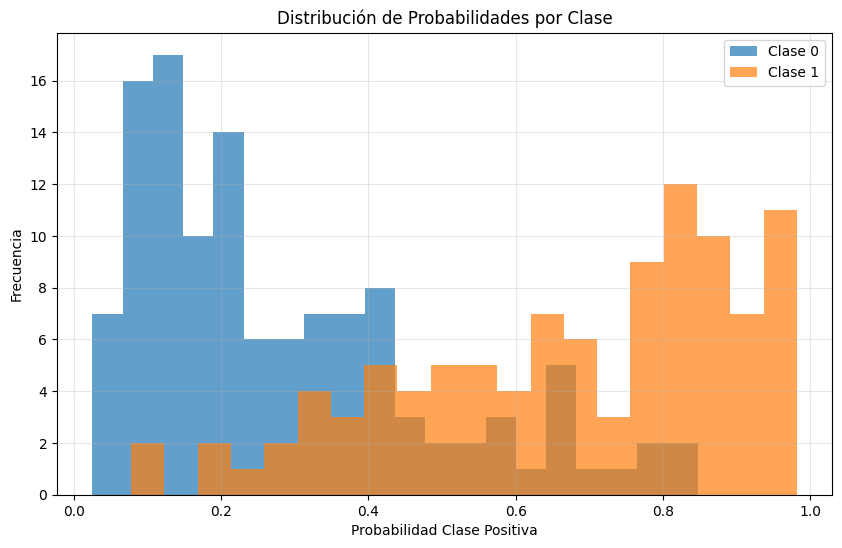

In [23]:
# Intentar crear una visualización simple
try:
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Convertir a pandas para visualización
    prob_df = test_predictions_full.select("probability", "label").toPandas()
    
    # Extraer probabilidades de clase positiva
    prob_df['prob_positive'] = prob_df['probability'].apply(lambda x: x[1])
    
    # Crear histograma
    plt.figure(figsize=(10, 6))
    for label in [0, 1]:
        subset = prob_df[prob_df['label'] == label]
        plt.hist(subset['prob_positive'], alpha=0.7, label=f'Clase {int(label)}', bins=20)
    
    plt.xlabel('Probabilidad Clase Positiva')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Probabilidades por Clase')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
except ImportError:
    print("Matplotlib no disponible para visualización")
except Exception as e:
    print(f"Error en visualización: {e}")

In [ ]:
print("\n" + "="*50)
print("🎊 ENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("="*50)
print(f"• AUC en prueba: {auc_full:.4f}")
print(f"• Exactitud: {accuracy:.4f}")
print(f"• Tamaño entrenamiento: {prepared_train.count()} filas")
print(f"• Tamaño prueba: {prepared_test.count()} filas")
print(f"• Características usadas: 6 (5 numéricas + Type)")
print("="*50)


🎊 ENTRENAMIENTO COMPLETADO EXITOSAMENTE
• AUC en prueba: 0.8888
• Exactitud: 0.8108
• Tamaño entrenamiento: 483 filas
• Tamaño prueba: 222 filas
• Características usadas: 6 (5 numéricas + Type)


25/11/26 05:01:21 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1033353 ms exceeds timeout 120000 ms
25/11/26 05:01:21 WARN SparkContext: Killing executors is not supported by current scheduler.
25/11/26 05:18:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$